<a href="https://colab.research.google.com/github/ChanceDurr/DS-Unit-2-Applied-Modeling/blob/master/module1-log-linear-regression/Chance_Dare_Log_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and csv's

In [0]:
import pandas as pd
from glob import glob
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
# !pip install category_encoders
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [0]:
# !wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip

In [0]:
# !unzip caterpillar-tube-pricing.zip

In [0]:
# !unzip data.zip

In [0]:
def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [0]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/type_end_form.csv (8, 2)
competition_data/comp_elbow.csv (178, 16)
competition_data/tube_end_form.csv (27, 2)
competition_data/type_connection.csv (14, 2)
competition_data/comp_adaptor.csv (25, 20)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/comp_sleeve.csv (50, 10)
competition_data/comp_straight.csv (361, 12)
competition_data/comp_hfl.csv (6, 9)
competition_data/components.csv (2048, 3)
competition_data/comp_float.csv (16, 7)
competition_data/comp_threaded.csv (194, 32)
competition_data/test_set.csv (30235, 8)
competition_data/comp_nut.csv (65, 11)
competition_data/tube.csv (21198, 16)
competition_data/train_set.csv (30213, 8)
competition_data/specs.csv (21198, 11)
competition_data/comp_other.csv (1001, 3)
competition_data/type_component.csv (29, 2)
competition_data/comp_boss.csv (147, 15)
competition_data/comp_tee.csv (4, 14)


In [0]:
train_set = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

#Train / Val Split

In [0]:
train_set['quote_date'] = pd.to_datetime(train_set['quote_date'], infer_datetime_format=True)

In [0]:
assemblies = train_set['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    assemblies, random_state=47)
print(train_tube_assemblies.shape)
print(val_tube_assemblies.shape)

(6641,)
(2214,)


In [0]:
train = train_set[train_set['tube_assembly_id'].isin(train_tube_assemblies)]
val = train_set[train_set['tube_assembly_id'].isin(val_tube_assemblies)]

#Validation RMSLE, Mean Baseline

In [0]:
target = 'cost'
y_pred = np.full_like(y_true, fill_value=train[target].mean())
y_true = val[target]
rmsle(y_pred, y_true)

0.950350338860588

# Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor

features = ['quantity']
target = 'cost'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

model = RandomForestRegressor(n_estimators=100, random_state=47)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

rmsle(y_pred, y_val)

0.687755369078692

In [0]:
model = RandomForestRegressor(n_estimators=100, random_state=47)
model.fit(X_train, np.log1p(y_train))
y_pred = model.predict(X_val)

rmsle(np.expm1(y_pred), y_val)

0.6208119734988891

In [0]:
tube = pd.read_csv('competition_data/tube.csv')

In [0]:
# Merge tube df on assembly id
train = pd.merge(train, tube, how='inner', on='tube_assembly_id')
val = pd.merge(val, tube, how='inner', on='tube_assembly_id')
test = pd.merge(test, tube, how='inner', on='tube_assembly_id')

In [0]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00004,S-0066,2013-07-07,0,0,Yes,5,6.668596,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,S-0066,2013-07-07,0,0,Yes,10,4.754539,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00004,S-0066,2013-07-07,0,0,Yes,25,3.608331,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0


In [0]:
features = ['quantity', 'length', 'num_bends',
            'bend_radius', 'diameter', 'end_a',
            'end_x', 'material_id', 'wall']
target = 'cost'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

model = RandomForestRegressor(n_estimators=100, random_state=47)
pipe = make_pipeline(OrdinalEncoder(), model)
pipe.fit(X_train, np.log1p(y_train))
y_pred = pipe.predict(X_val)

rmsle(np.expm1(y_pred), y_val)

0.4698358173843804

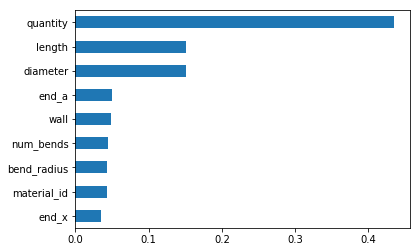

In [0]:
feature_importances = pd.Series(model.feature_importances_, features)
feature_importances.sort_values().plot.barh();

In [0]:
y_pred = pipe.predict(test[features])

In [0]:
test.head()

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0


In [0]:
sub = pd.DataFrame(data = {
    'id': test['id'],
    'cost': np.expm1(y_pred)
})
sub.to_csv('submission.csv', index=False)

In [0]:
sub.head()

,id,cost
0,1,2.697585
1,2,2.656465
2,3,2.234146
3,4,1.925307
4,5,1.671726
